In [1]:
import os
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score
import matplotlib  as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
from PIL import Image
from itertools import cycle
from random import randint
import re, math
import seaborn as sns; sns.set_style("white")
from sklearn.manifold import TSNE
import umap.umap_ as umap
import datetime
import gc
from pathlib import Path

import plotnine as gg
from cytominer_eval import evaluate
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.io as pio
pio.renderers

os.getcwd()

'/home/jovyan/maris/2022/Amelie_TX'

In [2]:
figformat = 'png'
dpi = 150

In [3]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)


    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

### Set output directory

In [4]:
OutputDir = input("Enter name for output folder: ") # 
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)

Enter name for output folder:  test


### Read data

In [5]:
BaseDir = './ImageMedianFeatures/'
sorted(os.listdir(BaseDir))

['ImageMediansAllPlates.csv',
 'ImageMediansPlateTX-Plate1-MDA-MB-231-48h-L01-GR-v2.csv',
 'ImageMediansPlateTX-Plate2-MDA-MB-231-48h-L02-GR-v2.csv']

In [6]:
df = pd.read_csv('{}/ImageMediansAllPlates.csv'.format(BaseDir), sep=';' , index_col=0)
df.head(1)

,ImageNumber_nuclei,ObjectNumber_nuclei,Metadata_Site_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm
ImageID,,,,,,,,,,,,,,,,,,,,,
TX-Plate1-MDA-MB-231-48h-L01-GR-v2_A01_1,1,87.5,1,1086.0,1558.0,1113.0,1223.5,1065.5,1175.0,1089.351105,...,-1.570796,0.327219,-0.338289,0.667024,0.203134,0.01767,-0.188584,-0.152211,0.556378,-0.008457


In [7]:
df['barcode'] = df.index.str[:9] 
df['well_id'] = df.index.str[-5:-2]
df['plateWell'] = df['barcode'] + '_' + df['well_id']
df['site'] = df.index.str[-1:]

In [8]:
df.tail(1)

,ImageNumber_nuclei,ObjectNumber_nuclei,Metadata_Site_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,barcode,well_id,plateWell,site
ImageID,,,,,,,,,,,,,,,,,,,,,
TX-Plate2-MDA-MB-231-48h-L02-GR-v2_P24_4,1,70.5,4,1148.5,1623.5,1111.5,1270.5,1066.0,1236.0,1086.969506,...,0.087714,-0.471151,-0.317849,-0.23688,-0.073115,-0.258089,TX-Plate2,P24,TX-Plate2_P24,4


In [9]:
Layout =  pd.read_csv('Texas-MDA-MB-231-48h-GR-v2_Edited.csv', sep=';')
Layout.head(1)

,layout_id,barcode,well_id,batch_id,pert_type,cmpd_conc,cmpd_conc_unit,DMSO_conc_well,DMSO_conc_unit,batch_id_2,cmpd_conc_2,compound_conc,OLA_conc,SAS_conc
0,TX-Plate1-MDA-MB-231-48h-L01-GR-v2,TX-Plate1,B02,OLA,trt,1.0,uM,0.2,perc,NaN,NaN,OLA_1,1.0,0


In [10]:
Layout['plateWell']= Layout['barcode'] + '_' + Layout['well_id']
Layout.head(1)

,layout_id,barcode,well_id,batch_id,pert_type,cmpd_conc,cmpd_conc_unit,DMSO_conc_well,DMSO_conc_unit,batch_id_2,cmpd_conc_2,compound_conc,OLA_conc,SAS_conc,plateWell
0,TX-Plate1-MDA-MB-231-48h-L01-GR-v2,TX-Plate1,B02,OLA,trt,1.0,uM,0.2,perc,NaN,NaN,OLA_1,1.0,0,TX-Plate1_B02


In [11]:
compound_concDict = dict(zip(Layout.plateWell, Layout.compound_conc))
pert_typeDict = dict(zip(Layout.plateWell, Layout.pert_type))
OLA_concDict = dict(zip(Layout.plateWell, Layout.OLA_conc))
SAS_concDict = dict(zip(Layout.plateWell, Layout.SAS_conc))

In [12]:
labels = ['compound_conc', 'pert_type', 'OLA_conc', 'SAS_conc']
for a in labels:
    df[a] = df['plateWell'].map(eval('{}Dict'.format(a)))

In [13]:
df.shape

(3065, 2134)

In [14]:
df.dropna(inplace=True)
df.reset_index(drop=False, inplace=True)
df.tail(1)

,ImageID,ImageNumber_nuclei,ObjectNumber_nuclei,Metadata_Site_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,barcode,well_id,plateWell,site,compound_conc,pert_type,OLA_conc,SAS_conc
2400,TX-Plate2-MDA-MB-231-48h-L02-GR-v2_O23_4,1,59.5,4,1484.0,2171.5,1201.0,1179.0,1149.5,1139.5,...,0.085114,-0.202559,TX-Plate2,O23,TX-Plate2_O23,4,OLA_7,trt,7.0,0.0


In [15]:
CompoundConcList = sorted(list(set(df['compound_conc'])))
print(CompoundConcList)
PertTypeList = sorted(list(set(df['pert_type'])))
print(PertTypeList)

['BEC_0.5', 'BEC_1', 'BEC_10', 'BEC_3', 'BEC_5', 'ETO_0.05', 'ETO_0.1', 'ETO_0.5', 'ETO_1', 'FEN_0.01', 'FEN_0.1', 'FEN_0.5', 'FEN_1', 'FLU_1', 'FLU_10', 'FLU_3', 'OLA_0.1', 'OLA_0.5', 'OLA_1', 'OLA_10', 'OLA_12', 'OLA_2', 'OLA_5', 'OLA_7', 'SAS_100', 'SAS_100_OLA_10', 'SAS_100_OLA_5', 'SAS_200', 'SAS_200_OLA_0.1', 'SAS_200_OLA_0.5', 'SAS_200_OLA_1', 'SAS_200_OLA_10', 'SAS_200_OLA_12', 'SAS_200_OLA_2', 'SAS_200_OLA_5', 'SAS_200_OLA_7', 'SAS_300', 'SAS_300_OLA_10', 'SAS_300_OLA_5', 'SAS_400', 'SAS_400_OLA_0.1', 'SAS_400_OLA_0.5', 'SAS_400_OLA_1', 'SAS_400_OLA_10', 'SAS_400_OLA_12', 'SAS_400_OLA_2', 'SAS_400_OLA_5', 'SAS_400_OLA_7', 'SAS_50', 'SAS_500', 'SAS_500_OLA_10', 'SAS_500_OLA_5', 'SAS_50_OLA_10', 'SAS_50_OLA_5', 'SAS_600', 'SAS_600_OLA_10', 'SAS_600_OLA_5', 'SOR_1', 'SOR_10', 'SOR_3', 'TET_0.5', 'TET_1', 'TET_10', 'TET_3', '[dmso]_0.2', '[dmso]_0.22', 'blank_0']
['blank', 'negcon', 'poscon', 'trt']


In [16]:
df['compound'] = df['compound_conc'].str.split('_').str[0]
df['conc'] = df['compound_conc'].str.split('_').str[1].astype(float)
df['conc2'] = df['compound_conc'].str.split('_').str[3].astype(float)
df['conc2'] = df['conc2'].fillna(0)
df['combination'] = np.where(df['compound_conc'].str.split('_').str[3].astype(float) > 0, 'yes', 'no')

### QC


In [17]:
QC =  pd.read_csv('./QC/3SD/3SD_Flags.csv', sep=';')
QC['ImageID'] = QC['Metadata_Barcode'] + '_' + QC['Metadata_Well'] + '_'  + QC['Metadata_Site'].astype(str)
QC.head(3)

,Unnamed: 0,Metadata_Barcode,Metadata_Well,Metadata_Site,Count_nuclei,ImageQuality_PowerLogLogSlope_CONC,ImageQuality_PowerLogLogSlope_HOECHST,ImageQuality_PowerLogLogSlope_MITO,ImageQuality_PowerLogLogSlope_PHAandWGA,ImageQuality_PowerLogLogSlope_SYTO,Outlier_PowerLogLogSlope_-2.3_-0.5,OutlierScaled_FocusScore_-3_3,OutlierScaled_MaxIntensity_-3_3,OutlierScaled_MeanIntensity_-3_3,OutlierScaled_PowerLogLogSlope_-3_3,OutlierScaled_StdIntensity_-3_3,Total,ImageID
0,0,TX-Plate1-MDA-MB-231-48h-L01-GR-v2,A01,1,157.0,-2.181605,-2.024415,-1.912317,-2.049866,-2.089124,0,0,0,0,0,0,0,TX-Plate1-MDA-MB-231-48h-L01-GR-v2_A01_1
1,1,TX-Plate1-MDA-MB-231-48h-L01-GR-v2,A01,2,155.0,-2.140985,-2.024510,-1.863402,-2.027347,-2.015948,0,0,0,0,0,0,0,TX-Plate1-MDA-MB-231-48h-L01-GR-v2_A01_2
2,2,TX-Plate1-MDA-MB-231-48h-L01-GR-v2,A01,3,288.0,-2.091037,-1.948896,-1.847400,-2.000450,-2.021054,0,0,0,1,0,0,1,TX-Plate1-MDA-MB-231-48h-L01-GR-v2_A01_3


In [18]:
df = df.merge(QC[['ImageID', 'Total', 'Count_nuclei']], left_on = 'ImageID', right_on = 'ImageID', how = 'left')
df = df[df['Total'] == 0]

In [19]:
df.reset_index(drop=True, inplace=True)
df['WellID'] =df['ImageID'].str[:-1]
df.tail(2)

,ImageID,ImageNumber_nuclei,ObjectNumber_nuclei,Metadata_Site_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,...,pert_type,OLA_conc,SAS_conc,compound,conc,conc2,combination,Total,Count_nuclei,WellID
2060,TX-Plate2-MDA-MB-231-48h-L02-GR-v2_O23_3,1,76.0,3,1431.0,1960.0,1092.0,1128.0,1033.0,1080.0,...,trt,7.0,0.0,OLA,7.0,0.0,no,0,136.0,TX-Plate2-MDA-MB-231-48h-L02-GR-v2_O23_
2061,TX-Plate2-MDA-MB-231-48h-L02-GR-v2_O23_4,1,59.5,4,1484.0,2171.5,1201.0,1179.0,1149.5,1139.5,...,trt,7.0,0.0,OLA,7.0,0.0,no,0,107.0,TX-Plate2-MDA-MB-231-48h-L02-GR-v2_O23_


In [20]:
print(sorted(list(set(df['compound']))))

['BEC', 'ETO', 'FEN', 'FLU', 'OLA', 'SAS', 'SOR', 'TET', '[dmso]', 'blank']


## Boxplots for single compounds

In [21]:
df_single = df[df['combination'] == 'no']
df_single.reset_index(drop=True, inplace=True)
df_single.shape

(1461, 2142)

In [22]:
print(sorted(list(set(df_single['compound']))))

['BEC', 'ETO', 'FEN', 'FLU', 'OLA', 'SAS', 'SOR', 'TET', '[dmso]', 'blank']


In [23]:
CompoundList = ['BEC', 'ETO', 'FEN', 'FLU', 'OLA', 'SAS',  'SOR', 'TET' ] # remove 'SASfiltered'

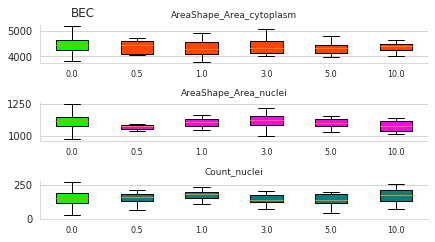

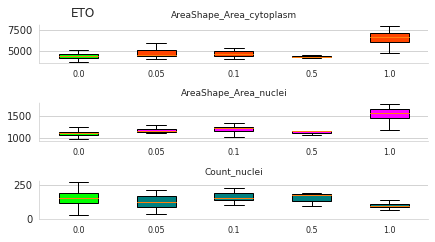

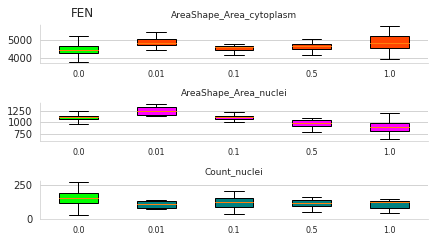

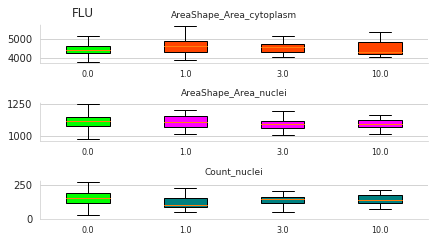

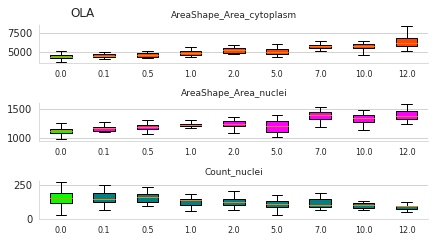

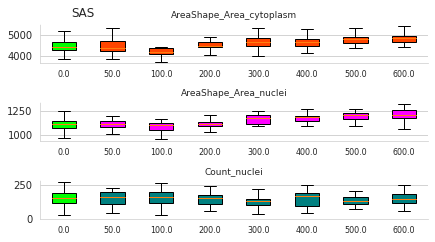

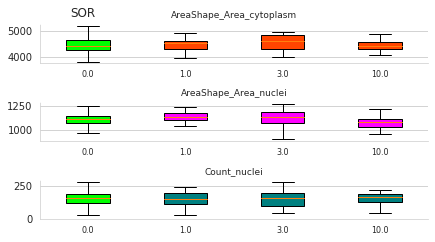

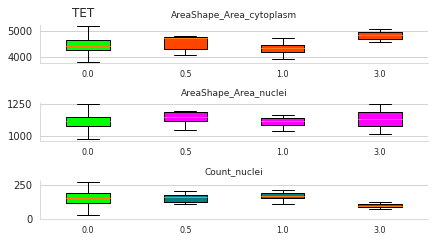

In [24]:

    FeatureList = ['AreaShape_Area_cytoplasm', 'AreaShape_Area_nuclei', 'Count_nuclei']
    colorList = ['orangered', 'magenta', 'teal']
    
    for comp in (CompoundList[:]):
        dfOneCompound = df_single.loc[(df_single['compound'] == comp), ['compound','conc']+ FeatureList]
        dfDMSO = df_single.loc[(df_single['compound'] == '[dmso]'), ['compound','conc']+ FeatureList]
        dfDMSO['conc'] = 0
                
        frames = [dfDMSO, dfOneCompound]
        dfOneCompoundandDMSO = pd.concat(frames, sort=False)
        dfOneCompoundandDMSO.sort_values(by = ['conc'], inplace = True)
        CompConcList = sorted(list(dict.fromkeys(list(dfOneCompoundandDMSO['conc']))))
        Legend = CompConcList
        
        fig = plt.figure(figsize = (6,3))
        fig.suptitle('{}'.format(comp), fontsize = 12, x=0.1)
        sp = 1
        for index, feature in enumerate(FeatureList):
            colors = ['lime'] + [colorList[index]]*(len(CompConcList)-1)
            ax = fig.add_subplot(3, math.ceil(len(FeatureList)/3),sp) 
            concentrations_thiscompound = []
            for comp_conc in  CompConcList:
                concentrations_thiscompound.append(dfOneCompoundandDMSO.loc[(dfOneCompoundandDMSO['conc'] == comp_conc)][feature].values)
            concentrations_thiscompound = np.array(concentrations_thiscompound, dtype=object)
            ax.set_title(feature, fontsize = 9, loc = 'center')
            bplot = ax.boxplot(concentrations_thiscompound, patch_artist=True, flierprops = None, showfliers=False)
            ax.set_xticklabels(labels=Legend, rotation = 0, Fontsize=8)

            ax.set_facecolor('w')
            ax.spines['bottom'].set_color('lightgrey')
            ax.spines['top'].set_color('w')
            ax.spines['left'].set_color('lightgrey')
            ax.spines['right'].set_color('w')
            ax.grid(visible=True, which='major', axis='y', color='lightgrey', linewidth=1)
            if sp == 3:
                ax.set_ylim([0, None])
            sp = sp + 1
            #plt.grid(axis = 'y')
            for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)
        plt.subplots_adjust(top=0.90,  wspace=0,  hspace=1, bottom=0.0, left =0.0)
        fig.savefig('{}/{}.{}'.format(OutputDir, comp, 'png'),  dpi=150, bbox_inches='tight')

 ### Specify feature columns

In [25]:
numeric_columns = list()
for a in df.columns:
    if (df.dtypes[a] == 'float64') | (df.dtypes[a] == 'int64') :
        numeric_columns.append(a)
print('Found {} numeric columns'.format(len(numeric_columns)))

Found 2132 numeric columns


In [26]:
feature_columns = [fc for fc in numeric_columns if ('Metadata' not in fc) & ('Number' not in fc) & ('conc' not in fc)]
print('Excluded columns that are "Metadata", etc.: {}'.format(len(feature_columns)))
X = df.loc[:, feature_columns]
X = X.loc[:, ((X.std() > 0.0001) & (X.std() < 100000))]
print('Excluded features with SD < 0.0001 and SD > 100000: {}'.format(X.shape[1]))
X.dropna(axis=1, inplace=True)
print('Removed features with missing values: {}'.format(X.shape[1]))
varying_features = list(X.columns)

Excluded columns that are "Metadata", etc.: 2107
Excluded features with SD < 0.0001 and SD > 100000: 1848
Removed features with missing values: 1848


In [27]:
varying_features[-5:]

['RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm',
 'RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm',
 'RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm',
 'RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm',
 'Count_nuclei']

### PCA for negcon and poscon

In [28]:
dfPart = df.loc[df['pert_type'].str.contains('con')]
dfPart.reset_index(inplace=True, drop=True)
dfPart.tail(1)

,ImageID,ImageNumber_nuclei,ObjectNumber_nuclei,Metadata_Site_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,...,pert_type,OLA_conc,SAS_conc,compound,conc,conc2,combination,Total,Count_nuclei,WellID
708,TX-Plate2-MDA-MB-231-48h-L02-GR-v2_O20_4,1,110.0,4,1136.0,1645.0,1051.0,1301.0,1013.0,1263.0,...,negcon,0.0,0.0,[dmso],0.2,0.0,no,0,186.0,TX-Plate2-MDA-MB-231-48h-L02-GR-v2_O20_


In [29]:
pca = PCA(n_components=4)
x = dfPart.loc[:, varying_features[:]].values
x = StandardScaler().fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
principalDf.rename(columns={0: 'principal component 1',
                            1: 'principal component 2', 2: 'principal component 3', 3: 'principal component 4'}, inplace=True)
principalDf.tail(1)

,principal component 1,principal component 2,principal component 3,principal component 4
708,-1.282969,-5.183827,13.187085,-16.109899


In [30]:
principalDf = principalDf.merge(dfPart[['compound', 'conc', 'pert_type',
                                        'ImageID', 'barcode', 'well_id', 'site']], left_index = True, right_index = True)

In [31]:
principalDf.to_csv('{}/PCA_negcon_poscon.csv'.format(OutputDir), sep=';')

In [32]:
sorted(list(set(principalDf['compound'])), reverse=True)

['[dmso]', 'TET', 'SOR', 'FLU', 'FEN', 'ETO', 'BEC']

In [33]:
targets = sorted(list(set(principalDf['compound'])), reverse=True)
colors= ['lime', 'blue', 'red', 'magenta', 'teal', 'black', 'yellow']

n = len(targets) - len(colors)
if n > 0:
    for i in range(n):
        colors.append('#%06X' % randint(0, 0xFFFFFF))

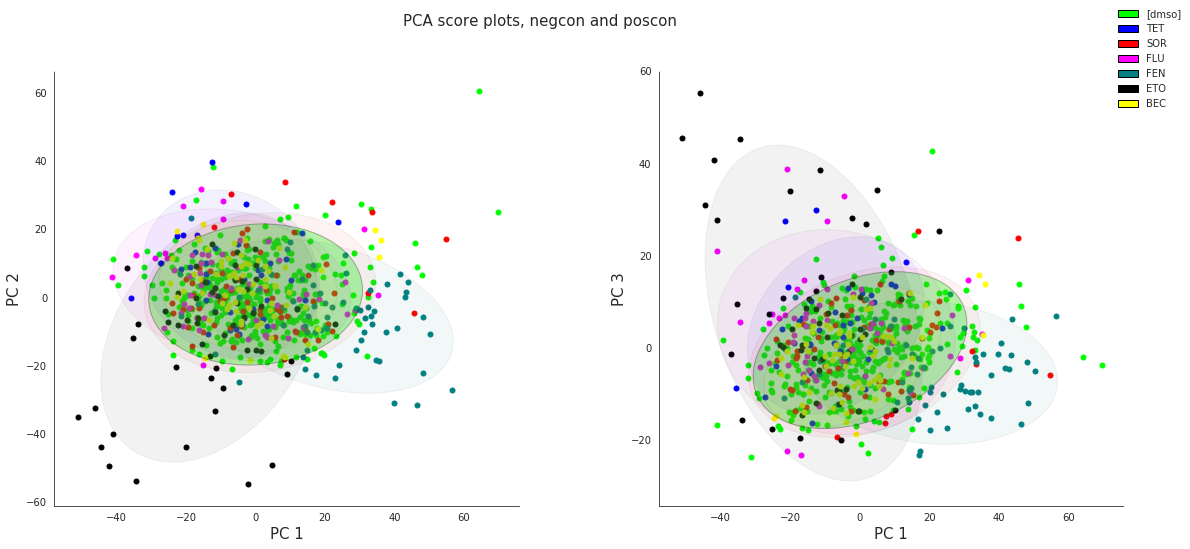

In [34]:
fig = plt.figure(figsize = (18,8))

ax = fig.add_subplot(1,2,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)

ax1 = fig.add_subplot(1,2,2) 
ax1.set_xlabel('PC 1', fontsize = 15)
ax1.set_ylabel('PC 3', fontsize = 15)


for target, color in zip(targets,colors):
    indicesToKeep = principalDf['compound'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 25)
    if target == '[dmso]':
        confidence_ellipse(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2'], ax, alpha = 0.3, facecolor=color, edgecolor = 'black')
    else:
        confidence_ellipse(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2'], ax, alpha = 0.05, facecolor=color, edgecolor = 'black')
    ax1.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 25)
    if target == '[dmso]':
        confidence_ellipse(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 3'], ax1, alpha = 0.3, facecolor=color, edgecolor = 'black')
    else:
        confidence_ellipse(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 3'], ax1, alpha = 0.05, facecolor=color, edgecolor = 'black')


leg = fig.legend(labels = targets, fontsize = 10, loc="upper right", frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
fig.suptitle('PCA score plots, negcon and poscon', fontsize = 15)
plt.subplots_adjust( wspace=0.3, right = 0.95)

ax.set_facecolor('w')
ax1.set_facecolor('w')    
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax1.spines['top'].set_color('white')
ax1.spines['right'].set_color('white')

fig.savefig('{}/PCA_negcon_poscon.{}'.format(OutputDir,  'png'),  dpi=300)
plt.show()

### UMAP

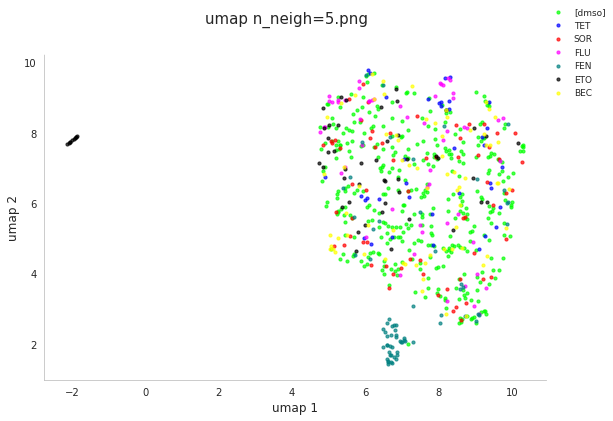

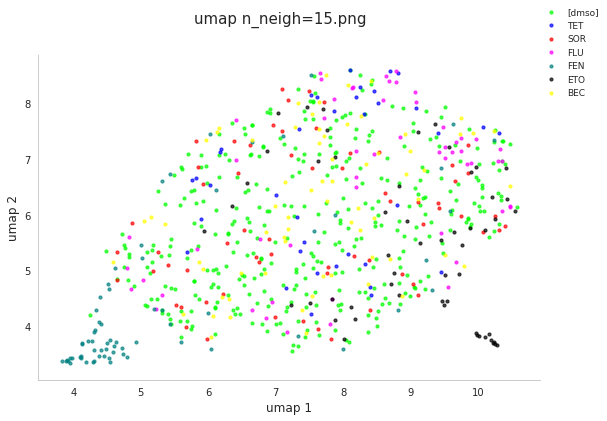

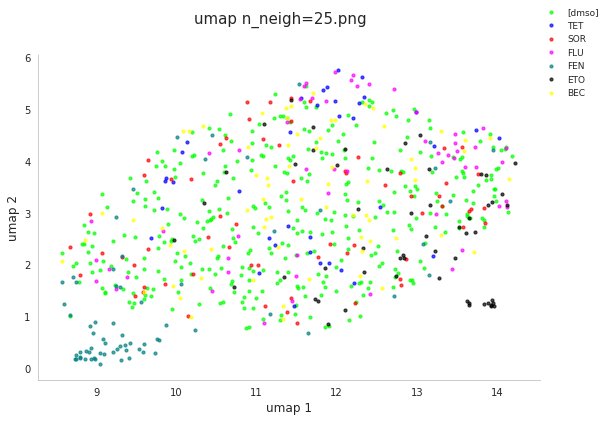

In [35]:
for n_neighbors in range(5, 30, 10):      
    reducer = umap.UMAP(n_neighbors = n_neighbors)
    embedding = reducer.fit_transform(x)
    umap_result = pd.DataFrame(data = embedding, columns=['umap 1', 'umap 2'])
    umap_resultDf = pd.concat([umap_result, dfPart[['compound', 'conc', 'pert_type',
                                        'ImageID', 'barcode', 'well_id', 'site']]], axis = 1)
                               
    fig = plt.figure(figsize = (9,6))

    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('umap 1', fontsize = 12)
    ax.set_ylabel('umap 2', fontsize = 12)

    for target, color in zip(targets,colors):
        indicesToKeep = umap_resultDf['compound'] == target
        ax.scatter(umap_resultDf.loc[indicesToKeep, 'umap 1']
                                       , umap_resultDf.loc[indicesToKeep, 'umap 2']
                                       , c = color
                                       , alpha =0.7
                                       , s = 10)
    #ax =sns.scatterplot(x='umap 1', y='umap 2',  
    #                      hue='compound', data=umap_resultDf, palette=colors, 
    #                        size='conc', sizes = (10, 50), alpha = 0.7,  marker = 'o');

    fig.legend(targets, fontsize = 9, loc="upper right", frameon=False)
    fig.suptitle('umap n_neigh={}.png'.format(n_neighbors), fontsize = 15)
    ax.set_facecolor('w')
    ax.spines['bottom'].set_color('silver')
    ax.spines['top'].set_color('w')
    ax.spines['left'].set_color('silver')
    ax.spines['right'].set_color('w')  

    fig.savefig('{}/umap_con_nneighb_{}.png'.format(OutputDir, n_neighbors),  dpi=150)
    plt.show()                               


### PCA for DMSO and single compounds

In [36]:
CompoundList = ['BEC', 'ETO', 'FEN', 'FLU', 'OLA', 'SAS',  'SOR', 'TET']

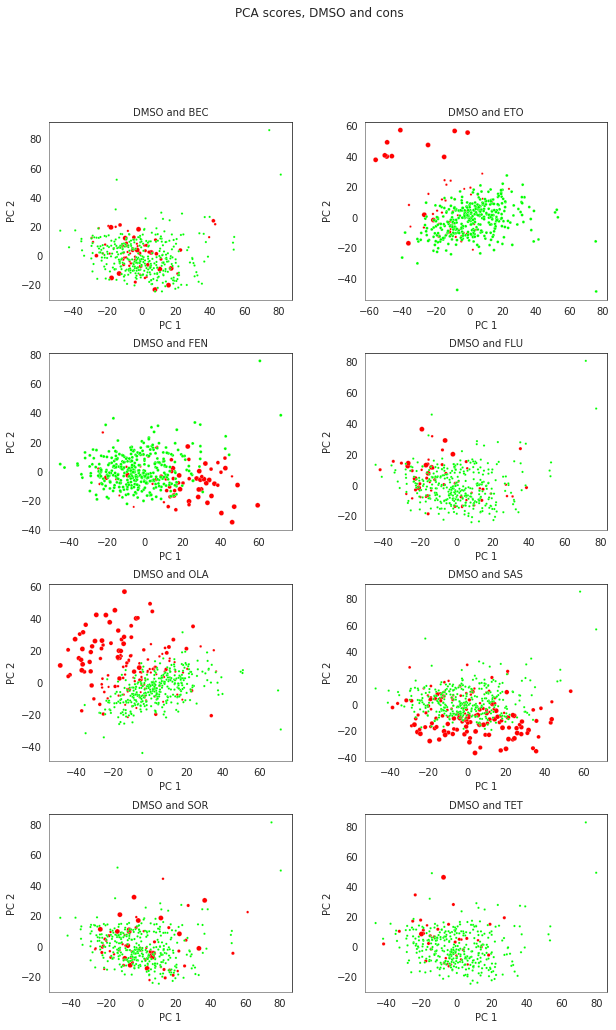

In [37]:
nrrow = 4 
nrcol = 2
colors = ['red', 'lime']

fig = plt.figure(figsize = (10,16))
sp = 1
for comp in (CompoundList):
        dfOneCompound = df_single.loc[((df_single['compound'] == comp) ), ['compound', 'conc'] + varying_features]
        dfDMSO = df_single.loc[((df_single['compound'] == '[dmso]') ), ['compound', 'conc'] + varying_features]
        frames = [dfOneCompound, dfDMSO]
        dfOneCompoundandDMSO = pd.concat(frames)
        dfOneCompoundandDMSO.reset_index(inplace=True, drop=True)
 
        x = dfOneCompoundandDMSO.loc[:, varying_features[:]].values
        pca = PCA(n_components=3)
        x = StandardScaler().fit_transform(x)
        principalComponents = pca.fit_transform(x)
        principalDf = pd.DataFrame(data = principalComponents)
        principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2', 2: 'principal component 3'}, inplace=True)
        principalDf = principalDf.merge(dfOneCompoundandDMSO[['compound','conc']], left_index = True, right_index = True)
        #principalDf.to_csv('{}/PCA_dmso_and_{}.csv'.format(OutputDir, comp), sep=';')

        
        ax = fig.add_subplot(nrrow, nrcol, sp) 
        ax.set_xlabel('PC 1', fontsize = 10)
        ax.set_ylabel('PC 2', fontsize = 10)
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        x
        ax =sns.scatterplot(x='principal component 1', y='principal component 2',  
                          hue='compound', data=principalDf, palette=colors, 
                            size='conc', sizes = (5, 25), alpha = 1,  marker = 'o');
        
        
        ax.set_title('DMSO and {}'.format(comp), fontsize = 10)
        ax.set_facecolor('w')
        ax.get_legend().remove()
        sp += 1
plt.subplots_adjust( wspace=0.3, hspace=0.3)
fig.suptitle('PCA scores, DMSO and cons'.format(), fontsize = 12)
fig.savefig('{}/PCA_DMSOandCons.{}'.format(OutputDir,  figformat),  dpi=dpi, bbox_inches='tight')
plt.show()

### Nicer plots for PCA of DMSO and some compound

(503, 8)


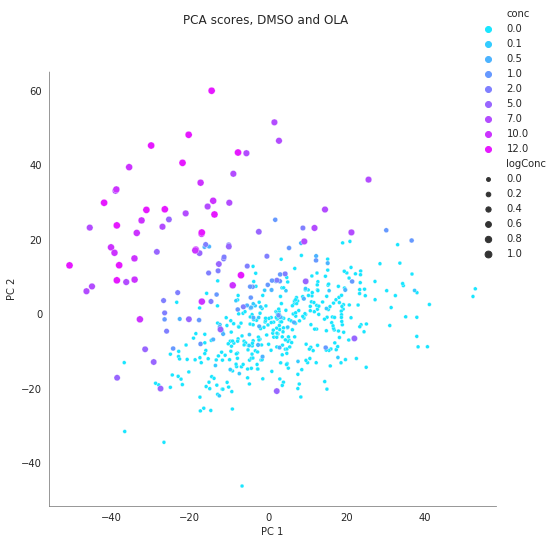

(503, 8)


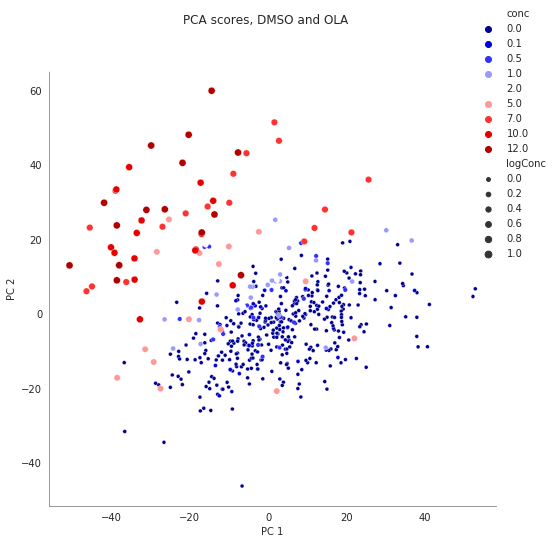

(503, 8)


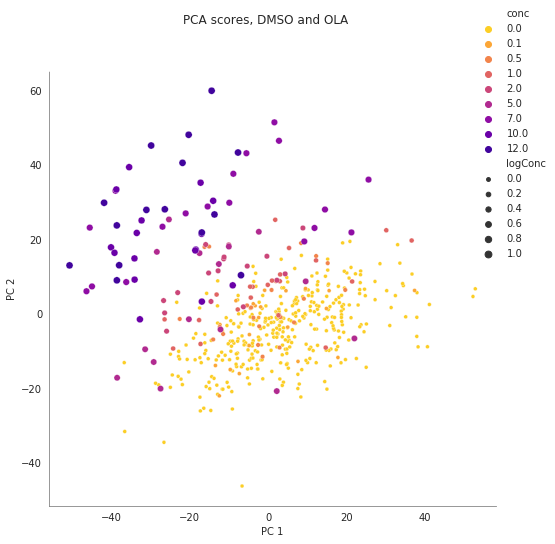

(508, 8)


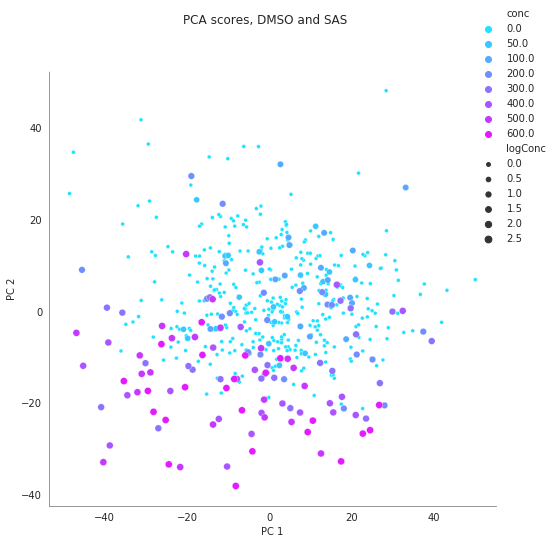

(508, 8)


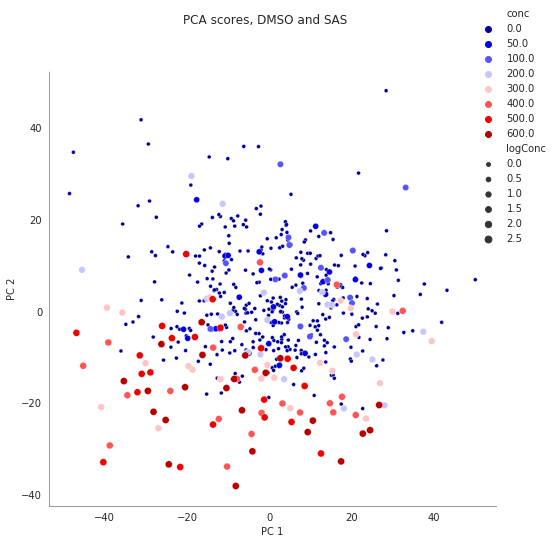

(508, 8)


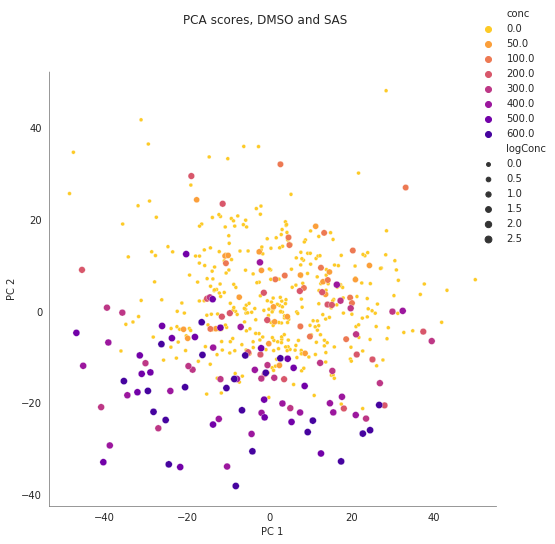

In [38]:
minimal_nr_cells = 35 # consider only images with at least ... cells
palettes = ['cool', 'seismic', 'plasma_r'] # select colormap
sizes = (15, 50)  # sizes of markers

for comp in ['OLA', 'SAS']: # select compound
    for palette in palettes:
        fig = plt.figure(figsize = (8,8))


        dfOneCompound = df_single.loc[((df_single['compound'] == comp) ), ['compound', 'conc', 'ImageID'] + varying_features]
        dfDMSO = df_single.loc[((df_single['compound'] == '[dmso]') ), ['compound', 'conc', 'ImageID'] + varying_features]
        dfDMSO['conc'] = 0
        frames = [dfOneCompound, dfDMSO]
        dfOneCompoundandDMSO = pd.concat(frames)
        dfOneCompoundandDMSO.sort_values(by='conc', inplace=True)
        dfOneCompoundandDMSO = dfOneCompoundandDMSO[dfOneCompoundandDMSO['Count_nuclei'] > minimal_nr_cells]
        dfOneCompoundandDMSO.reset_index(inplace=True, drop=True)
        dfOneCompoundandDMSO['logConc'] = np.log10(dfOneCompoundandDMSO['conc'] + 1)
        dfOneCompoundandDMSO['conc'] = dfOneCompoundandDMSO['conc'].astype(str)
        x = dfOneCompoundandDMSO.loc[:, varying_features[:]].values
        pca = PCA(n_components=3)
        x = StandardScaler().fit_transform(x)
        principalComponents = pca.fit_transform(x)
        principalDf = pd.DataFrame(data = principalComponents)
        principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2', 2: 'principal component 3'}, inplace=True)
        principalDf = principalDf.merge(dfOneCompoundandDMSO[['compound','conc', 'logConc', 'ImageID','Count_nuclei']], left_index = True, right_index = True)
        #principalDf.to_csv('{}/PCA_dmso_and_{}.csv'.format(OutputDir, comp), sep=';')
        print(principalDf.shape)
        
        ax = fig.add_subplot(111) 
        ax.set_xlabel('PC 1', fontsize = 10)
        ax.set_ylabel('PC 2', fontsize = 10)
        ax.spines['top'].set_color('w')
        ax.spines['right'].set_color('w')
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        
        ax =sns.scatterplot(x='principal component 1', y='principal component 2',  
                          hue='conc', data=principalDf, palette=palette, 
                            size='logConc', sizes = sizes,
                            alpha = 1,  marker = 'o');
        
        
        
        ax.set_facecolor('w')
        ax.get_legend().remove()
        leg = fig.legend(fontsize = 10, loc="upper right", frameon=False)
        plt.subplots_adjust( wspace=0, hspace=0)
        fig.suptitle('PCA scores, DMSO and {}'.format(comp), fontsize = 12)
        fig.savefig('{}/PCA_DMSOand{}_{}.{}'.format(OutputDir, comp, palette, figformat),  dpi=dpi, bbox_inches='tight')
        plt.show()

### UMAP for DMSO and some compound

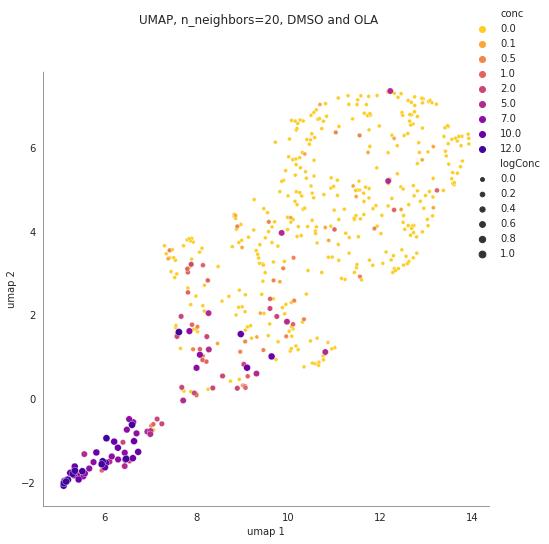

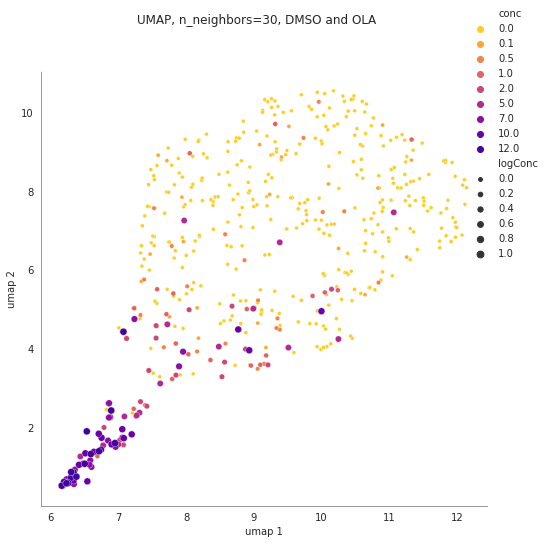

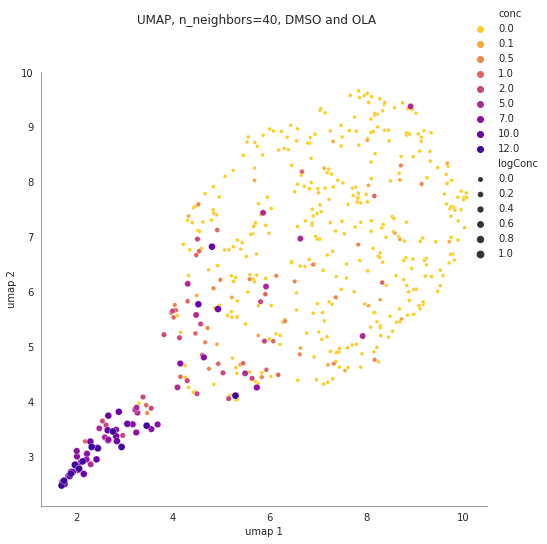

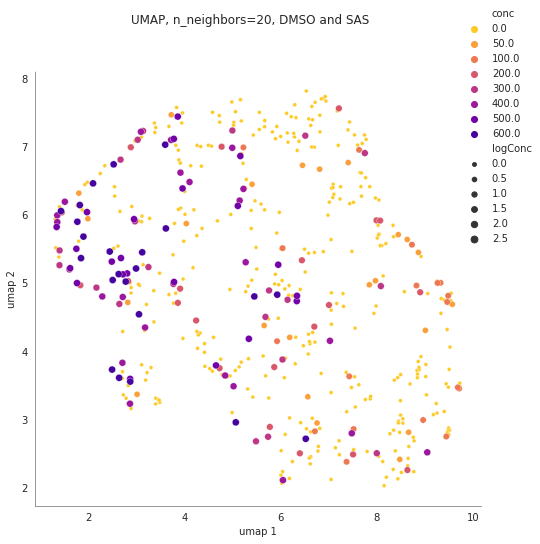

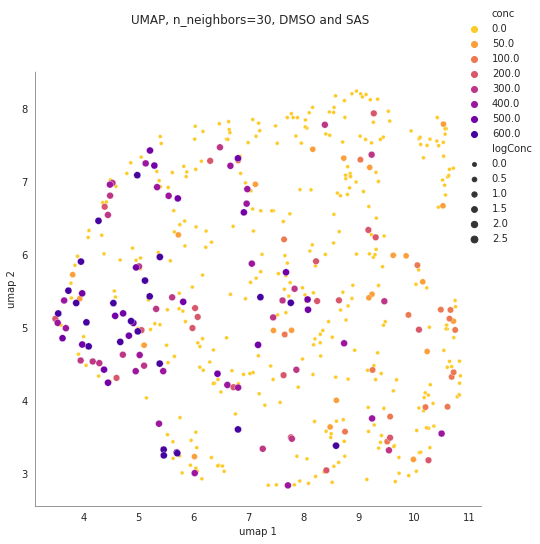

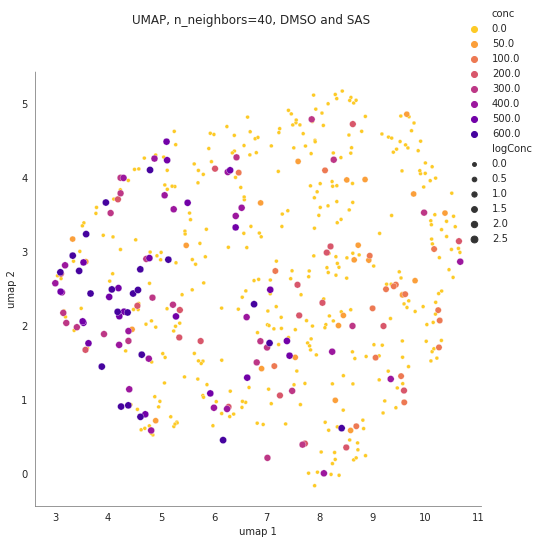

In [39]:
minimal_nr_cells = 35 # consider only images with at least ... cells
palette = 'plasma_r' # select colormap
sizes = (15, 50)  # sizes of markers

for comp in ['OLA', 'SAS']: # select compound
    for n_neighbors in range(20, 45, 10):  # number of neighbors for UMAP 
        fig = plt.figure(figsize = (8,8))


        dfOneCompound = df_single.loc[((df_single['compound'] == comp) ), ['compound', 'conc', 'ImageID'] + varying_features]
        dfDMSO = df_single.loc[((df_single['compound'] == '[dmso]') ), ['compound', 'conc', 'ImageID'] + varying_features]
        dfDMSO['conc'] = 0
        frames = [dfOneCompound, dfDMSO]
        dfOneCompoundandDMSO = pd.concat(frames)
        dfOneCompoundandDMSO.sort_values(by='conc', inplace=True)
        dfOneCompoundandDMSO = dfOneCompoundandDMSO[dfOneCompoundandDMSO['Count_nuclei'] > minimal_nr_cells]
        dfOneCompoundandDMSO.reset_index(inplace=True, drop=True)
        dfOneCompoundandDMSO['logConc'] = np.log10(dfOneCompoundandDMSO['conc'] + 1)
        dfOneCompoundandDMSO['conc'] = dfOneCompoundandDMSO['conc'].astype(str)
        x = dfOneCompoundandDMSO.loc[:, varying_features[:]].values
        
              
        reducer = umap.UMAP(n_neighbors = n_neighbors)
        embedding = reducer.fit_transform(x)
        umap_result = pd.DataFrame(data = embedding, columns=['umap 1', 'umap 2'])
        umap_resultDf = pd.concat([umap_result, dfOneCompoundandDMSO[['compound', 'conc', 'logConc', 
                                        'ImageID', 'Count_nuclei']]], axis = 1)
        
        
        ax = fig.add_subplot(111) 
        ax.set_xlabel('umap 1', fontsize = 10)
        ax.set_ylabel('umap 2', fontsize = 10)
        ax.spines['top'].set_color('w')
        ax.spines['right'].set_color('w')
        ax.spines['left'].set_color('grey')
        ax.spines['bottom'].set_color('grey')
        x
        ax =sns.scatterplot(x='umap 1', y='umap 2',  
                          hue='conc', data=umap_resultDf, palette=palette, 
                            size='logConc', sizes = sizes,
                            alpha = 1,  marker = 'o');
        
        
        
        ax.set_facecolor('w')
        ax.get_legend().remove()
        leg = fig.legend(fontsize = 10, loc="upper right", frameon=False)
        plt.subplots_adjust( wspace=0, hspace=0)
        fig.suptitle('UMAP, n_neighbors={}, DMSO and {}'.format(n_neighbors, comp), fontsize = 12)
        fig.savefig('{}/UMAP_{}neighbors_DMSOand{}_{}.{}'.format(OutputDir, n_neighbors, comp, palette, figformat),  dpi=dpi, bbox_inches='tight')
        plt.show()

### Clustermap for DMSO, OLA and SAS

### Calculate z-scores

In [40]:
dfDMSO = df[df['compound'] == '[dmso]']
dfDMSO_Medians = dfDMSO[varying_features].median() 

In [41]:
dfDMSO_MADs = (dfDMSO[varying_features] - dfDMSO[varying_features].median()).abs().median()
dfDMSO_MADs

AreaShape_Area_nuclei                                       36.500000
AreaShape_BoundingBoxArea_nuclei                            55.000000
AreaShape_BoundingBoxMaximum_X_nuclei                      110.500000
AreaShape_BoundingBoxMaximum_Y_nuclei                      115.500000
AreaShape_BoundingBoxMinimum_X_nuclei                      112.000000
                                                              ...    
RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm      0.209276
RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm      0.214791
RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm      0.193170
RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm      0.207807
Count_nuclei                                                37.000000
Length: 1848, dtype: float64

In [42]:
print(len(varying_features))
varying_in_DMSO = dfDMSO_MADs.loc[dfDMSO_MADs > 0.0001].index # remove features that are invariant or close to invariant in DMSO
len(varying_in_DMSO)

1848


1676

In [45]:
dfZscores = df[varying_features].copy()
dfZscores = (df[varying_features] - dfDMSO_Medians[varying_features])/dfDMSO_MADs[varying_features]
dfZscores.dropna(axis=1, inplace=True)
dfZscores = dfZscores.merge(df[['compound','conc','compound_conc', 'combination']], left_index=True, right_index=True) 
dfZscores.tail(1)

,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,AreaShape_ConvexArea_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,Count_nuclei,compound,conc,compound_conc,combination
2061,10.136986,10.572727,1.493213,0.415584,1.379464,0.467249,1.474201,0.466638,1.832218,10.958904,...,0.356187,-1.649416,-1.282333,0.422329,-1.121999,-1.351351,OLA,7.0,OLA_7,no


In [46]:
dfZscores = df[varying_in_DMSO].copy()
dfZscores = (df[varying_in_DMSO] - dfDMSO_Medians[varying_in_DMSO])/dfDMSO_MADs[varying_in_DMSO]
dfZscores.dropna(axis=1, inplace=True)
# dfZscores = dfZscores.clip(lower=-100, upper=100) # HERE I CAN CLIP EXTREME VALUES
dfZscores = dfZscores.merge(df[['compound','conc','compound_conc', 'combination', 'SAS_conc', 'OLA_conc']], left_index=True, right_index=True) 
dfZscores.tail(1)

,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,AreaShape_ConvexArea_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,Count_nuclei,compound,conc,compound_conc,combination,SAS_conc,OLA_conc
2061,10.136986,10.572727,1.493213,0.415584,1.379464,0.467249,1.474201,0.466638,1.832218,10.958904,...,-1.282333,0.422329,-1.121999,-1.351351,OLA,7.0,OLA_7,no,0.0,7.0


In [47]:
dfZscoresSingleComp = dfZscores.loc[dfZscores['combination'] =='no'] # Remove combinations

In [48]:
SomeCompounds = ['[dmso]', 'OLA', 'SAS']

In [49]:
dfSomeCompounds = dfZscoresSingleComp[dfZscoresSingleComp['compound'].isin(SomeCompounds)]                              

In [50]:
dfSomeCompounds.columns

Index(['AreaShape_Area_nuclei', 'AreaShape_BoundingBoxArea_nuclei',
       'AreaShape_BoundingBoxMaximum_X_nuclei',
       'AreaShape_BoundingBoxMaximum_Y_nuclei',
       'AreaShape_BoundingBoxMinimum_X_nuclei',
       'AreaShape_BoundingBoxMinimum_Y_nuclei', 'AreaShape_Center_X_nuclei',
       'AreaShape_Center_Y_nuclei', 'AreaShape_Compactness_nuclei',
       'AreaShape_ConvexArea_nuclei',
       ...
       'RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm',
       'RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm',
       'Count_nuclei', 'compound', 'conc', 'compound_conc', 'combination',
       'SAS_conc', 'OLA_conc'],
      dtype='object', length=1682)

In [55]:
dictOfnumeric = { i : np.nanmean for i in dfSomeCompounds.columns[2:-7]}
groupedby = dfSomeCompounds.groupby('compound_conc').agg(dictOfnumeric)
groupedby['compound'] = groupedby.index.str.split('_').str[0]
groupedby['conc'] = groupedby.index.str.split('_').str[1].astype('float')
groupedby.sort_values(['compound', 'conc'], inplace=True)
groupedby.drop(columns=['compound', 'conc'], inplace=True)
groupedby

,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,AreaShape_ConvexArea_nuclei,AreaShape_Eccentricity_nuclei,AreaShape_EquivalentDiameter_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_7_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm
compound_conc,,,,,,,,,,,,,,,,,,,,,
OLA_0.1,-0.333196,-0.070445,-0.329951,-0.005955,-0.345154,-0.036841,0.521114,0.945828,-0.296662,0.904979,...,0.322733,0.029032,0.055839,-0.049775,-0.292757,0.328076,-0.005851,0.021612,-0.148163,0.045681
OLA_0.5,0.182230,-0.122393,0.145698,-0.096268,0.154334,-0.107486,-0.162326,2.262765,-0.030117,2.088106,...,0.276549,0.442030,-0.024554,-0.070199,-0.168465,0.121177,0.602873,-0.368758,0.175799,-0.278413
OLA_1,0.410903,0.001443,0.400085,0.016428,0.402233,0.006312,1.400407,2.804958,0.415481,2.471290,...,0.351381,-0.127025,0.506315,-0.292975,0.048096,0.277850,0.328424,-0.184460,-0.825834,-0.058550
OLA_2,0.514240,-0.299465,0.492910,-0.250450,0.502117,-0.277515,1.765275,3.524577,1.283818,3.054983,...,-0.374525,-0.423190,0.438819,-0.473839,-0.427946,0.318435,-0.050293,-0.026035,-0.103200,0.164608
OLA_5,0.409785,0.086310,0.404576,0.099072,0.400383,0.094554,7.909041,0.819349,-0.824144,-0.333253,...,-0.032911,-0.594753,-0.747613,0.743889,-0.283760,-0.293795,0.047643,0.343974,-0.610289,0.113711
OLA_7,0.102815,-0.036075,0.065476,-0.024260,0.075835,-0.025862,1.034213,7.621005,0.000626,6.799557,...,-0.730485,-0.214272,0.052752,0.586350,0.435222,-0.318165,0.202149,0.365762,0.785207,-0.201400
OLA_10,0.791290,-0.103896,0.694754,-0.099891,0.745197,-0.103271,2.154204,6.635274,-0.964005,5.589084,...,-0.236152,0.128875,0.313136,-0.272728,0.338580,0.095262,-0.186429,-0.034392,-0.117103,-0.856002
OLA_12,0.523190,-0.776515,0.471261,-0.745360,0.511766,-0.755220,3.999536,7.788527,-1.342476,6.667410,...,-0.585390,-0.583753,0.125993,-0.005974,0.473866,0.116679,-1.220665,-0.605462,1.271043,-0.038975
SAS_50,0.435570,0.074722,0.440994,0.115436,0.440152,0.094425,1.099219,-0.101251,-0.096972,-0.320586,...,-0.438263,0.306671,0.352564,0.393889,0.297862,-0.108904,-0.024099,-0.457597,0.546864,-0.454358


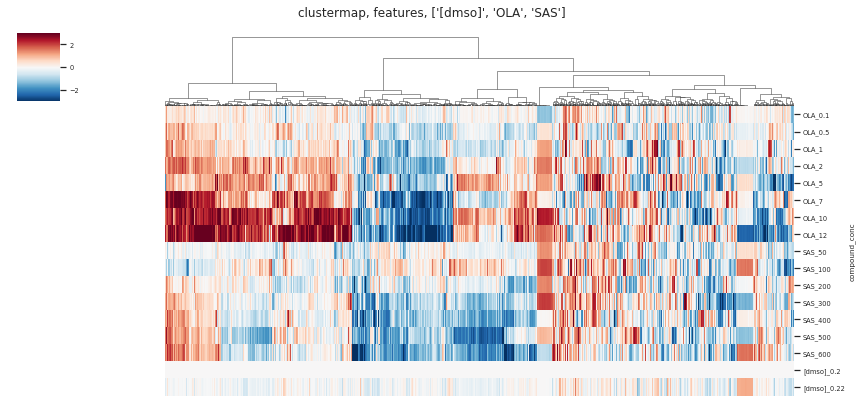

In [56]:
nr_rows = groupedby.shape[0]

x = groupedby.values 
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, index = groupedby.index)
x = x - x.loc['[dmso]_0.2']

sns.set(font_scale=0.6)
sns_plot = sns.clustermap(x, method='ward', metric='euclidean', z_score=None,
                       standard_scale=None,  cbar_kws=None, figsize=(12, nr_rows/4 +1), 
                       row_cluster=False, col_cluster=True,
                       cbar_pos=(0.02, 0.8, 0.05, 0.18), 
                       row_linkage=None, col_linkage=None, row_colors=None,
                              vmin =-3, vmax=3,
                       col_colors=None, cmap="RdBu_r", xticklabels=False )
plt.suptitle('clustermap, features, {}'.format(SomeCompounds) , fontsize = 12, y=1.05)
sns_plot.savefig('{}/clustermap_OLA_SAS_c.{}'.format(OutputDir, figformat),  dpi=dpi)
plt.show()

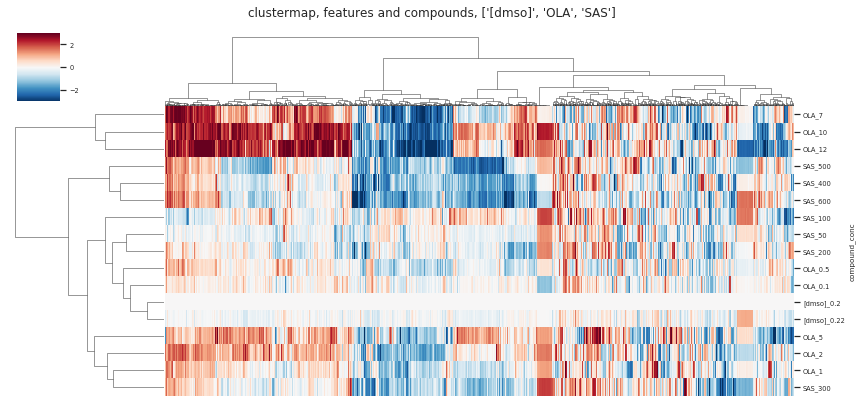

In [57]:
nr_rows = groupedby.shape[0]

x = groupedby.values 
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, index = groupedby.index)
x = x - x.loc['[dmso]_0.2']

sns.set(font_scale=0.6)
sns_plot = sns.clustermap(x, method='ward', metric='euclidean', z_score=None,
                       standard_scale=None,  cbar_kws=None, figsize=(12, nr_rows/4 +1), 
                       row_cluster=True, col_cluster=True,
                       cbar_pos=(0.02, 0.8, 0.05, 0.18), 
                       row_linkage=None, col_linkage=None, row_colors=None,
                              vmin =-3, vmax=3,
                       col_colors=None, cmap="RdBu_r", xticklabels=False )
plt.suptitle('clustermap, features and compounds, {}'.format(SomeCompounds)  , fontsize = 12, y=1.05)
sns_plot.savefig('{}/clustermap_OLA_SAS_rc.{}'.format(OutputDir, figformat),  dpi=dpi)
plt.show()

### Grit

In [58]:
dataset= dfZscoresSingleComp.copy()
dataset['CompRepl'] = dataset['compound'] + '_' + dataset.index.astype(str) #dataset.concentration.astype(str)# 
datasetPart =  dataset
datasetPart.iloc[:, :-10] = datasetPart.iloc[:, :-10].clip(lower=-100, upper=100)
datasetPart.head(1)

,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,AreaShape_ConvexArea_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,Count_nuclei,compound,conc,compound_conc,combination,SAS_conc,OLA_conc,CompRepl
0,5.315068,3.890909,0.746606,-0.398268,0.776786,-0.445415,0.77022,-0.425639,2.979201,5.575342,...,-3.334732,-0.064864,-2.054054,OLA,1.0,OLA_1,no,0.0,1.0,OLA_0


In [64]:
features = list(datasetPart.columns[2:-7])
meta_features = list(datasetPart.columns[-7:])

meta_features

['compound',
 'conc',
 'compound_conc',
 'combination',
 'SAS_conc',
 'OLA_conc',
 'CompRepl']

In [65]:
control_perts = datasetPart.query("compound == '[dmso]'").CompRepl.unique().tolist()

In [66]:
grit_replicate_groups = {
    "profile_col": "CompRepl",
    "replicate_group_col": "compound_conc"
}

In [67]:
grit_scores = []

#for cell_line in datasetPart.plate.unique():
#    cell_line_df = datasetPart.query("plate == @cell_line")
    
grit_results = evaluate(
        profiles=datasetPart,
        features=features,
        meta_features=meta_features,
        replicate_groups=grit_replicate_groups,
        operation="grit",
        similarity_metric="pearson",
        grit_replicate_summary_method="median",
        grit_control_perts=control_perts
    )#.assign(cell_line=cell_line)

grit_scores.append(grit_results)

In [68]:
grit_scores = pd.concat(grit_scores).reset_index(drop=True)
print(grit_scores.shape)
grit_scores.head()

(1461, 3)


,perturbation,group,grit
0,BEC_1026,BEC_1,-0.243419
1,BEC_1027,BEC_1,0.272529
2,BEC_1028,BEC_1,0.462847
3,BEC_1287,BEC_3,0.174677
4,BEC_1288,BEC_3,0.055522


In [69]:
grit_scores['compound'] = grit_scores['perturbation'].str.split('_').str[0]
grit_scores['conc'] = grit_scores['group'].str.split('_').str[1].astype(float)
grit_scores.tail()

,perturbation,group,grit,compound,conc
1456,blank_961,blank_0,0.364631,blank,0.0
1457,blank_962,blank_0,0.187314,blank,0.0
1458,blank_963,blank_0,-0.357556,blank,0.0
1459,blank_996,blank_0,0.072287,blank,0.0
1460,blank_997,blank_0,0.124468,blank,0.0


In [70]:
grit_scores.to_csv('{}/grit_scores.csv'.format(OutputDir), sep=';')

In [71]:
grit_scores_grouped = grit_scores.groupby('group').mean()
grit_scores_grouped['compound'] = grit_scores_grouped.index.str.split('_').str[0]
grit_scores_grouped['conc'] = grit_scores_grouped.index.str.split('_').str[1].astype(float)
grit_scores_grouped.to_csv('{}/grit_scores_grouped.csv'.format(OutputDir), sep=';')
grit_scores_grouped.head(8)

,grit,conc,compound
group,,,
BEC_0.5,-0.144844,0.50,BEC
BEC_1,0.355676,1.00,BEC
BEC_10,0.234982,10.00,BEC
BEC_3,0.705108,3.00,BEC
BEC_5,-0.034428,5.00,BEC
ETO_0.05,-0.101337,0.05,ETO
ETO_0.1,0.225041,0.10,ETO
ETO_0.5,1.193652,0.50,ETO


In [72]:
CompoundsUsed= sorted(list(set(grit_scores['compound'])))
print(CompoundsUsed)

['BEC', 'ETO', 'FEN', 'FLU', 'OLA', 'SAS', 'SOR', 'TET', '[dmso]', 'blank']


In [73]:
CompoundsUsed = ['BEC', 'ETO', 'FEN', 'FLU', 'OLA', 'SAS', 'SOR', 'TET', '[dmso]'] # removed 'SASfiltered'

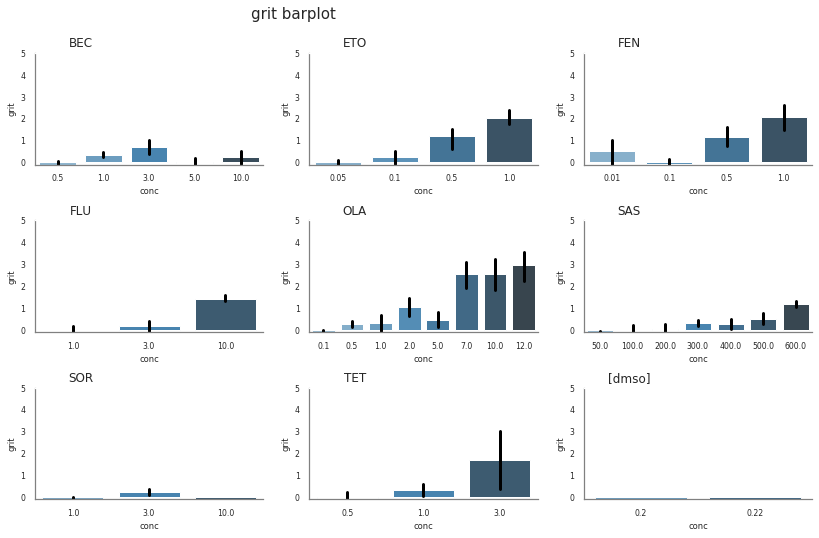

In [74]:
fig = plt.figure(figsize = (12,8))
sns.set(font_scale = 0.7)
fig.suptitle('grit barplot', fontsize = 15, x=0.3)
sp = 1
nrrow = 3 
nrcol = 3
for some in CompoundsUsed[:]:
    grit_scores_part = grit_scores[grit_scores['compound'] == some].copy()
    grit_scores_part.sort_values(by='conc', inplace=True)
    ax = fig.add_subplot(nrrow, nrcol, sp) 
    ax = sns.barplot(x="conc", y="grit", data=grit_scores_part, palette="Blues_d",
                 alpha=1, errcolor='black', errwidth=3)
    ax.set_facecolor('w')
    ax.spines['bottom'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.set_ylim([-0.1, 5])
    ax.set_title('{}'.format(some), fontsize = 12, x=0.2)
    plt.subplots_adjust(top=0.9,  wspace=0.2,  hspace=0.5,  left =0.0)
    sp += 1
fig.savefig('{}/grit_barplots.{}'.format(OutputDir, 'png'),  dpi=150, bbox_inches='tight')
fig.savefig('{}/grit_barplots.{}'.format(OutputDir, 'pdf'),  dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
    stop here

### Combinations of fixed dose of SAS with different doses of olaparib

In [ ]:
df_comb = df[(df['compound'] == 'SAS') | (df['compound'] == '[dmso]')]
df_comb.reset_index(drop=True, inplace=True)
df_comb.shape

In [ ]:
print(sorted(list(set(df_comb['compound_conc']))))

In [ ]:
ConcOfFirstAgent = ['200', '400']

FeatureList = ['AreaShape_Area_cytoplasm', 'AreaShape_Area_nuclei', 'Count_nuclei']
colorList = ['orangered', 'magenta', 'teal']

for conc in (ConcOfFirstAgent):                    
    CompoundList = ['SAS']
    for comp in (CompoundList):
        dfOneConc = df_comb.loc[(df_comb['compound_conc'].str.contains(conc)), ['conc', 'conc2'] + FeatureList]
        dfOneConc['conc2'] = dfOneConc['conc2'].fillna(0)
        dfDMSO = df_comb.loc[(df_comb['compound'] == '[dmso]'), ['conc','conc2']+ FeatureList]
        dfDMSO['conc'] = -99
        dfDMSO['conc2'] = -99        
        frames = [dfDMSO, dfOneConc]
        dfTwoCompoundsandDMSO = pd.concat(frames, sort=False)
        dfTwoCompoundsandDMSO.sort_values(by = ['conc2'], inplace = True)
        CompConcList = sorted(list(dict.fromkeys(list(dfTwoCompoundsandDMSO['conc2']))))
        Legend = CompConcList.copy()
        Legend[0] = 'DMSO'
        
        fig = plt.figure(figsize = (6,3))
        fig.suptitle('{} {} + olaparib'.format(comp, conc), fontsize = 12, x=0.1)
        sp = 1
        for index, feature in enumerate(FeatureList):
            colors = ['lime'] + [colorList[index]]*(len(CompConcList)-1)
            ax = fig.add_subplot(3, math.ceil(len(FeatureList)/3),sp) 
            concentrations_thiscompound = []
            for comp_conc in  CompConcList:
                concentrations_thiscompound.append(dfTwoCompoundsandDMSO.loc[(dfTwoCompoundsandDMSO['conc2'] == comp_conc)][feature].values)
            concentrations_thiscompound = np.array(concentrations_thiscompound, dtype=object)
            ax.set_title(feature, fontsize = 9, loc = 'center')
            bplot = ax.boxplot(concentrations_thiscompound, patch_artist=True, flierprops = None, showfliers=False)
            ax.set_xticklabels(labels=Legend, rotation = 0, Fontsize=8)

            ax.set_facecolor('w')
            ax.spines['bottom'].set_color('lightgrey')
            ax.spines['top'].set_color('w')
            ax.spines['left'].set_color('lightgrey')
            ax.spines['right'].set_color('w')
            ax.grid(visible=True, which='major', axis='y', color='lightgrey', linewidth=1)
            if sp == 3:
                ax.set_ylim([0, None])
            sp = sp + 1
            #plt.grid(axis = 'y')
            for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)
        plt.subplots_adjust(top=0.90,  wspace=0,  hspace=1, bottom=0.0, left =0.0)
        fig.savefig('{}/combinations_{}_{}.{}'.format(OutputDir, comp, conc, 'png'),  dpi=150, bbox_inches='tight')

### Combinations of fixed dose of OLA with different doses of sulfasalazine

In [ ]:
df_comb2 = df[(df['compound_conc'].str.contains('OLA')) | (df['compound'] == '[dmso]')].copy()

df_comb2['conc2'] = np.where(df_comb2['compound'] == 'OLA', df_comb2['conc'], df_comb2['conc2'])
df_comb2['conc'] = np.where(df_comb2['compound'] == 'OLA', 0, df_comb2['conc'])
df_comb2.reset_index(drop=True, inplace=True)
df_comb2.head(2)

In [ ]:
print(sorted(list(set(df_comb2['compound_conc']))))

In [ ]:
ConcOfSecondAgent = ['5', '10']

FeatureList = ['AreaShape_Area_cytoplasm', 'AreaShape_Area_nuclei', 'Count_nuclei']
colorList = ['orangered', 'magenta', 'teal']

for conc in (ConcOfSecondAgent):                    
    CompoundList = ['OLA']
    for comp in (CompoundList):
        dfOneConc = df_comb2.loc[(df_comb2['compound_conc'].str.endswith(conc)), ['conc', 'conc2'] + FeatureList]
        #dfOneConc['conc2'] = dfOneConc['conc2'].fillna(dfOneConc['conc'])
        dfDMSO = df_comb2.loc[(df_comb2['compound'] == '[dmso]'), ['conc','conc2']+ FeatureList]
        dfDMSO['conc'] = -99
        dfDMSO['conc2'] = -99        
        frames = [dfDMSO, dfOneConc]
        dfTwoCompoundsandDMSO = pd.concat(frames, sort=False)
        dfTwoCompoundsandDMSO.sort_values(by = ['conc'], inplace = True)
        CompConcList = sorted(list(dict.fromkeys(list(dfTwoCompoundsandDMSO['conc']))))
        Legend = CompConcList.copy()
        Legend[0] = 'DMSO'
        
        fig = plt.figure(figsize = (6,3))
        fig.suptitle('{} {} + sulfasalazine'.format(comp, conc), fontsize = 12, x=0.1)
        sp = 1
        for index, feature in enumerate(FeatureList):
            colors = ['lime'] + [colorList[index]]*(len(CompConcList)-1)
            ax = fig.add_subplot(3, math.ceil(len(FeatureList)/3),sp) 
            concentrations_thiscompound = []
            for comp_conc in  CompConcList:
                concentrations_thiscompound.append(dfTwoCompoundsandDMSO.loc[(dfTwoCompoundsandDMSO['conc'] == comp_conc)][feature].values)
            concentrations_thiscompound = np.array(concentrations_thiscompound, dtype=object)
            ax.set_title(feature, fontsize = 9, loc = 'center')
            bplot = ax.boxplot(concentrations_thiscompound, patch_artist=True, flierprops = None, showfliers=False)
            ax.set_xticklabels(labels=Legend, rotation = 0, Fontsize=8)

            ax.set_facecolor('w')
            ax.spines['bottom'].set_color('lightgrey')
            ax.spines['top'].set_color('w')
            ax.spines['left'].set_color('lightgrey')
            ax.spines['right'].set_color('w')
            ax.grid(visible=True, which='major', axis='y', color='lightgrey', linewidth=1)
            if sp == 3:
                ax.set_ylim([0, None])
            sp = sp + 1
            #plt.grid(axis = 'y')
            for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)
        plt.subplots_adjust(top=0.90,  wspace=0,  hspace=1, bottom=0.0, left =0.0)
        fig.savefig('{}/combinations_{}_{}.{}'.format(OutputDir, comp, conc, 'png'),  dpi=150, bbox_inches='tight')

In [ ]:
sas_ola_Zscores = dfZscores[(dfZscores['compound'] == 'SAS') | (dfZscores['compound'] == 'OLA') | (dfZscores['compound'] == '[dmso]')]
sas_ola_Zscores.reset_index(drop=True, inplace=True)
sas_ola_Zscores.head(1)

In [ ]:
print(sorted(list(set(sas_ola_Zscores['compound_conc']))))

In [ ]:
dataset= sas_ola_Zscores.copy()
dataset['CompRepl'] = dataset['compound_conc'] + '_' + dataset.index.astype(str) #dataset.concentration.astype(str)# 
datasetPart =  dataset
datasetPart.iloc[:, :-10] = datasetPart.iloc[:, :-10].clip(lower=-100, upper=100)
datasetPart.head(1)

In [ ]:
features = list(datasetPart.columns[2:-5])
meta_features = list(datasetPart.columns[-5:])
meta_features

In [ ]:
control_perts = datasetPart.query("compound == '[dmso]'").CompRepl.unique().tolist()

In [ ]:
grit_replicate_groups = {
    "profile_col": "CompRepl",
    "replicate_group_col": "compound_conc"
}

In [ ]:
grit_scores = []

#for cell_line in datasetPart.plate.unique():
#    cell_line_df = datasetPart.query("plate == @cell_line")
    
grit_results = evaluate(
        profiles=datasetPart,
        features=features,
        meta_features=meta_features,
        replicate_groups=grit_replicate_groups,
        operation="grit",
        similarity_metric="pearson",
        grit_replicate_summary_method="median",
        grit_control_perts=control_perts
    )#.assign(cell_line=cell_line)

grit_scores.append(grit_results)

In [ ]:
grit_scores = pd.concat(grit_scores).reset_index(drop=True)
print(grit_scores.shape)
grit_scores.head()

In [ ]:
grit_scores_grouped = grit_scores.groupby('group').mean()
#grit_scores_grouped['compound'] = grit_scores_grouped.index.str.split('_').str[0]
#grit_scores_grouped['conc'] = grit_scores_grouped.index.str.split('_').str[1].astype(float)
#grit_scores_grouped.to_csv('{}/grit_scores_grouped.csv'.format(OutputDir), sep=';')
grit_scores_grouped.head(8)

In [ ]:
fixed = ['SAS_200', 'SAS_400']

fig = plt.figure(figsize = (12,4))
fig.suptitle('grit barplot, {}'.format(fixed), fontsize = 15, x=0.3)
sp = 1
nrrow = 1 
nrcol = 2
sns.set(font_scale = 1)

for f in fixed:
    
    fixed_conc = float(f.split('_')[-1])
    grit_scores_grouped_SAS = grit_scores[grit_scores.group.str.contains(f)].copy()
    grit_scores_grouped_SAS['conc'] = grit_scores_grouped_SAS.group.str.split('_').str[-1].astype(float)
    grit_scores_grouped_SAS['conc'] = np.where(grit_scores_grouped_SAS['conc']==fixed_conc, 0, grit_scores_grouped_SAS['conc'])
    grit_scores_grouped_SAS.sort_values('conc', inplace=True)
    grit_scores_grouped_SAS.reset_index(inplace=True)
    ax = fig.add_subplot(nrrow, nrcol, sp) 
    ax = sns.barplot(x="group", y="grit", data=grit_scores_grouped_SAS, palette="Blues_d",
                     alpha=1, errcolor='black', errwidth=3)
    ax.set_facecolor('w')
    ax.spines['bottom'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.set_ylim([-0.1, 5])

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(9) 
        tick.label.set_rotation(70)
    sp += 1
    #ax.set_title('{}'.format(some), fontsize = 12, x=0.2)
plt.subplots_adjust(top=0.9,  wspace=0.2,  hspace=0.5,  left =0.0)
    
fig.savefig('{}/grit_barplot_{}.{}'.format(OutputDir, fixed, 'png'),  dpi=150, bbox_inches='tight')
    #fig.savefig('{}/grit_barplots.{}'.format(OutputDir, 'pdf'),  dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fixed = ['OLA_5', 'OLA_10']

fig = plt.figure(figsize = (12,4))
fig.suptitle('grit barplot, {}'.format(fixed), fontsize = 15, x=0.3)
sp = 1
nrrow = 1 
nrcol = 2
sns.set(font_scale = 1)

for f in fixed:
    
    fixed_conc = float(f.split('_')[-1])
    grit_scores_grouped_OLA = grit_scores[grit_scores.group.str.contains(f)].copy()
    grit_scores_grouped_OLA['conc'] = grit_scores_grouped_OLA.group.str.split('_').str[1].astype(float)
    grit_scores_grouped_OLA['conc'] = np.where(grit_scores_grouped_OLA['conc']==fixed_conc, 0, grit_scores_grouped_OLA['conc'])
    grit_scores_grouped_OLA.sort_values('conc', inplace=True)
    grit_scores_grouped_OLA.reset_index(inplace=True)
    ax = fig.add_subplot(nrrow, nrcol, sp) 
    ax = sns.barplot(x="group", y="grit", data=grit_scores_grouped_OLA, palette="Blues_d",
                     alpha=1, errcolor='black', errwidth=3)
    ax.set_facecolor('w')
    ax.spines['bottom'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.set_ylim([-0.1, 5])

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(9) 
        tick.label.set_rotation(70)
    sp += 1
    #ax.set_title('{}'.format(some), fontsize = 12, x=0.2)
plt.subplots_adjust(top=0.9,  wspace=0.2,  hspace=0.5,  left =0.0)
    
fig.savefig('{}/grit_barplot_{}.{}'.format(OutputDir, fixed, 'png'),  dpi=150, bbox_inches='tight')
    #fig.savefig('{}/grit_barplots.{}'.format(OutputDir, 'pdf'),  dpi=300, bbox_inches='tight')
plt.show()

### PCA for ...

In [ ]:
df.head(1)

In [ ]:
df_OLA_SAS = df[(df['compound_conc'].str.contains('OLA')) |(df['compound_conc'].str.contains('SAS'))].copy()

df_OLA_SAS.to_csv('test.csv', sep=';')
print(df_OLA_SAS.shape)
df_DMSO = df[df['compound'] == '[dmso]'].copy()
df_DMSO['SAS_conc'] = -99
df_DMSO['OLA_conc'] = -99
print(df_DMSO.shape)
frames = [df_DMSO, df_OLA_SAS]
df_OLA_SAS_DMSO = pd.concat(frames, sort=False, ignore_index=True)

df_OLA_SAS_DMSO = df_OLA_SAS_DMSO[df_OLA_SAS_DMSO['Count_nuclei'] > 50]
df_OLA_SAS_DMSO.reset_index(inplace=True, drop=True)
print(df_OLA_SAS_DMSO.shape)
df_OLA_SAS_DMSO.head(1)

In [ ]:
df_OLA_5 = df_OLA_SAS_DMSO[(df_OLA_SAS_DMSO['OLA_conc']==5)| (df_OLA_SAS_DMSO['OLA_conc']==-99)].copy()
df_OLA_5.sort_values('SAS_conc', inplace=True)
df_OLA_5.reset_index(inplace=True, drop=True)
print(df_OLA_5.shape)

In [ ]:
x = df_OLA_5.loc[:, varying_features].values
pca = PCA(n_components=3)
x = StandardScaler().fit_transform(x)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)
principalDf.rename(columns={0: 'principal component 1', 1: 'principal component 2', 2: 'principal component 3'}, inplace=True)
principalDf = principalDf.merge(df_OLA_5[['compound_conc', 'SAS_conc', 'OLA_conc']], left_index = True, right_index = True)
principalDf['SAS conc'] = principalDf['SAS_conc'].astype(str)
principalDf['size'] = principalDf['SAS_conc']+150
principalDf.to_csv('test.csv', sep=';')
principalDf.head()

In [ ]:
colors = ['grey', 'deeppink', 'salmon', 'orange', 'yellowgreen', 'lightseagreen', 'steelblue', 'blue',  'midnightblue']
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111) 
ax.set_xlabel('PC 1', fontsize = 10)
ax.set_ylabel('PC 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax.set_facecolor('w')

ax =sns.scatterplot(x='principal component 1', y='principal component 2',  
                          hue='SAS conc', data=principalDf, palette=colors, 
                            #size='size', sizes = (20, 50),
                            alpha = 0.7,  marker = 'o', s =100);
# ax.get_legend().remove()
#CompConcList = sorted(list(dict.fromkeys(list(df_OLA_5['SAS_conc']))))
#Legend = CompConcList.copy()
#Legend1 = [str(x) for x in Legend]
#Legend1[0] = 'DMSO'

#leg = fig.legend(Legend1, fontsize = 10, loc="upper right", frameon=False)
fig.suptitle('PCA, OLA 5 + SAS'.format(), fontsize = 12)
plt.subplots_adjust( wspace=0, hspace=0, right=0.8)
fig.savefig('{}/PCA_OLA5.{}'.format(OutputDir, 'png'),  dpi=150, bbox_inches='tight')

### UMAP

In [ ]:
n_neighbors = 5

x = df_OLA_5.loc[:, varying_features].values
x = StandardScaler().fit_transform(x)

reducer = umap.UMAP(n_neighbors = n_neighbors)
embedding = reducer.fit_transform(x)
umap_result = pd.DataFrame(data = embedding, columns=['umap 1', 'umap 2'])
umap_resultDf = pd.concat([umap_result, df_OLA_5[['compound_conc', 'SAS_conc', 'OLA_conc']]], axis = 1)

umap_resultDf['SAS conc'] = principalDf['SAS_conc'].astype(str)
umap_resultDf['size'] = principalDf['SAS_conc']+150
umap_resultDf.head()

In [ ]:
colors = ['grey', 'deeppink', 'salmon', 'orange', 'yellowgreen', 'lightseagreen', 'steelblue', 'blue',  'midnightblue']

x = df_OLA_5.loc[:, varying_features].values
x = StandardScaler().fit_transform(x)

for n_neighbors in range(10, 45, 10):
    reducer = umap.UMAP(n_neighbors = n_neighbors)
    embedding = reducer.fit_transform(x)
    umap_result = pd.DataFrame(data = embedding, columns=['umap 1', 'umap 2'])
    umap_resultDf = pd.concat([umap_result, df_OLA_5[['compound_conc', 'SAS_conc', 'OLA_conc']]], axis = 1)

    umap_resultDf['SAS conc'] = principalDf['SAS_conc'].astype(str)
    umap_resultDf['size'] = principalDf['SAS_conc']+150
    umap_resultDf.head()



    fig = plt.figure(figsize = (12,8))
    ax = fig.add_subplot(111) 
    ax.set_xlabel('UMAP 1', fontsize = 10)
    ax.set_ylabel('UMAP', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax.set_facecolor('w')

    ax =sns.scatterplot(x='umap 1', y='umap 2',  
                              hue='SAS conc', data=umap_resultDf, palette=colors, 
                                #size='size', sizes = (20, 50),
                                alpha = 0.7,  marker = 'o', s =100);
    # ax.get_legend().remove()
    #CompConcList = sorted(list(dict.fromkeys(list(df_OLA_5['SAS_conc']))))
    #Legend = CompConcList.copy()
    #Legend1 = [str(x) for x in Legend]
    #Legend1[0] = 'DMSO'

    #leg = fig.legend(Legend1, fontsize = 10, loc="upper right", frameon=False)
    fig.suptitle('UMAP, OLA 5 + SAS, n_neighbors={}'.format(n_neighbors), fontsize = 12)
    plt.subplots_adjust( wspace=0, hspace=0, right=0.8)
    fig.savefig('{}/UMAP_OLA5_{}neighbors.{}'.format(OutputDir, n_neighbors,'png'),  dpi=150, bbox_inches='tight')
    plt.show()

### PLS-DA